# Прогнозирование оттока клиентов

## 1. Введение.

### Описание проекта

В этом проекте мы будем решать задачу прогнозирования оттока клиентов. Выстраивание взаимоотношений с клиентами или customer relationship managmenet (CRM) является важным звеном в функционировании любого бизнеса. От того, насколько хорошо простроена работа с аудиторией зачастую зависит успех всей компании. Суть задачи заключается в заблаговременном нахождении сегмента пользователей, склонных через некоторый промежуток времени отказаться от использования некоторого продукта или услуги. Точное и своевременное нахождение таких пользователей позволяет эффективно бороться с их оттоком, например, выявлять причины оттока и принимать меры по удержанию клиентов. Эта задача актуальна для большинства организаций, оказывающих услуги в сегменте B2C и вдвойне актуальна в областях, где распространение услуги близко к отметке 100%. Хороший пример такой области – рынок мобильной связи, где насыщение уже фактически произошло, и как следствие постепенно снижается прирост клиентской базы. В такой ситуации задача удержания клиентов и выстраивания с ними взаимоотношений выходит на первый план.

### Цель проекта

Основная цель проекта - научиться определять пользователей, склонных к оттоку. 

Если заблаговременно находить таких пользователей, то можно эффективно управлять оттоком, а именно определять причины оттока и  проводить кампании по удержанию.

### Задачи проекта

На основании цели проекта были поставлены следующие задачи:
1. Исследовать имеющиеся данные, произвести их анализ и на основании результатов анализа подготовить признаки для построения модели.
2. Определить оптимальные метрики для оценки качества будущей модели и подобрать оптимальный алгоритм на основе baseline - решения для дальнейшего построения модели.
3. Выбрать оптимальную стратегию обработки исходных данных и подобрать оптимальные параметры выбранного алгоритма.
4. Построить модель прогнозирования оттока и оценить качество модели, как на тренироочных, так и на тестовых данных.
5. Оценить предполагаемый эконмический эффект от использования модели.
6. Продумать возможность внедрения модели и ее автоматизации для применения на практике.

## 2. Техническая часть.

#### Импорт библиотек

In [100]:
# отключаем предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import itertools
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.utils import shuffle
import sklearn.metrics as sm
import random
import seaborn as sns
import xgboost as xgb
from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
# уберем ограничения на вывод максимального количества строк и столбцов (будет необходимо при просмотре загруженных данны в датасет)
# pd.options.display.max_rows = None
# pd.options.display.max_columns = None
# включаем множественый вывод результата
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### 2.1. Исследование исходных данных.

Данные были предоставлены французской телекоммуникационной компанией Orange. В задаче речь идет о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Мы будем работать с набором данных orange small dataset. Он состоит из 40 тыс. объектов (32 тыс. - обучающий датасет, 8 тыс. - holdout датасет) и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные.

#### Загрузим исходные данные. Выделим целевую переменную и данные для обучения.

In [2]:
train_data = pd.read_csv('churn_data_train.csv')
test_data = pd.read_csv('churn_data_holdout.csv')
labels_data_train = train_data['labels'].copy()
labels_data_test = test_data['labels'].copy()
train_data.drop(['labels'], axis = 1, inplace = True)
test_data.drop(['labels'], axis = 1, inplace = True)
train_data.shape, test_data.shape, labels_data_train.shape, labels_data_test.shape

((32000, 230), (8000, 230), (32000,), (8000,))

In [3]:
numeric_features_data = train_data.columns[:190].tolist()
categorial_features_data = train_data.columns[190:].tolist()
train_data[numeric_features_data] = train_data[numeric_features_data].astype(float)
test_data[numeric_features_data] = test_data[numeric_features_data].astype(float)
train_data[categorial_features_data] = train_data[categorial_features_data].astype(object)
test_data[categorial_features_data] = test_data[categorial_features_data].astype(object)

In [4]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Columns: 230 entries, Var1 to Var230
dtypes: float64(190), object(40)
memory usage: 56.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 230 entries, Var1 to Var230
dtypes: float64(190), object(40)
memory usage: 14.0+ MB


#### Рассчитаем доли классов `отток` и `не отток`.

In [5]:
churn_count = labels_data_train[labels_data_train == 1].shape[0]
churn_count
non_churn_count = labels_data_train[labels_data_train == -1].shape[0]
non_churn_count

2381

29619

In [6]:
churn_portion = churn_count/ labels_data_train.shape[0]
non_churn_portion = non_churn_count/ labels_data_train.shape[0]
round(churn_portion,4)
round(non_churn_portion,4)

0.0744

0.9256

Видно, что классы в нашей выборке несбалансированы, гораздо больше пользователей соответсвующих классу `не отток`.

#### Рассчитаем корреляцию признаков с целевой переменной.

#### Корреляция вещественных признаков.

Рассчитаем меру взаимосвязи между каждым из вещественных признаков и целевой переменной (бинарный признак). 
Поскольку целевая переменная бинарная, то нам не подойдет расчет корреляции Пирсона (или любой другой) и нужно считать  разность математического ожидания вещественного признака при условии, что целевая переменная принимает значение 1 и математического ожидания вещественного признака при условии, что целевая переменная принимает значение -1.

В качестве меры связанности целевой переменной и признака будем пользоваться уровнем значимости гипотезы о том, что распределения признака для обоих классов совпадают. Уровень значимости гипотезы будем подсчитывать с использованием критерия Манна - Уитни.

Для начала заполним все пропущенные значения вещественных признаков на 0 (данный признак не будет давать вклад в модель).

In [8]:
diff_numeric = abs(train_data.loc[labels_data_train == 1, numeric_features_data].mean() - train_data.loc[labels_data_train == -1, numeric_features_data].mean())

# проверим, значимо ли отличаются средние для обоих классов в каждом признаке
p_values = list()
for i, feat in enumerate(numeric_features_data):
    label0 = train_data.loc[labels_data_train == -1, feat].dropna()
    label1 = train_data.loc[labels_data_train == 1, feat].dropna()
    if len(label0) < 10 or len(label1) < 10:
        p_value = 1
    else:
        p_value = ss.mannwhitneyu(label0, label1)[1]
    p_values.append(p_value)

# Сохраним и отсортируем получившиеся разности матожиданий и достигаемые уровни значимости.
mns_and_ps = pd.DataFrame({'mean_diff': diff_numeric, 'p_value': p_values}).sort_values('p_value')
mns_and_ps.head()

,mean_diff,p_value
Var189,41.126505,2.120687e-52
Var74,48.529692,2.447737e-52
Var13,453.945154,2.290238e-44
Var7,1.663922,2.061510e-40
Var140,467.107028,2.479551e-40


In [9]:
result_numeric_features = list(mns_and_ps[mns_and_ps['p_value'] < 0.01].index)

In [10]:
len(result_numeric_features)

28

Воспользовавшись критерием Манна-Уитни получили, что для 28 вещественных признаков была отвергнута нулевая гипотеза на уровне значимости 0.01, о том, что распределения признаков для обоих классов (`отток` и `не отток`) совпадают. 

#### Сделаем визуализацию данных для вещественных признаков ( Для примера рассмотрим топ 16 из 28 вещественных признаков, наиболее сильно коррелирующих с целевой переменной и для этих переменных построим распределения в разрезе классов и отобразим объекты в координатах пар признаков).

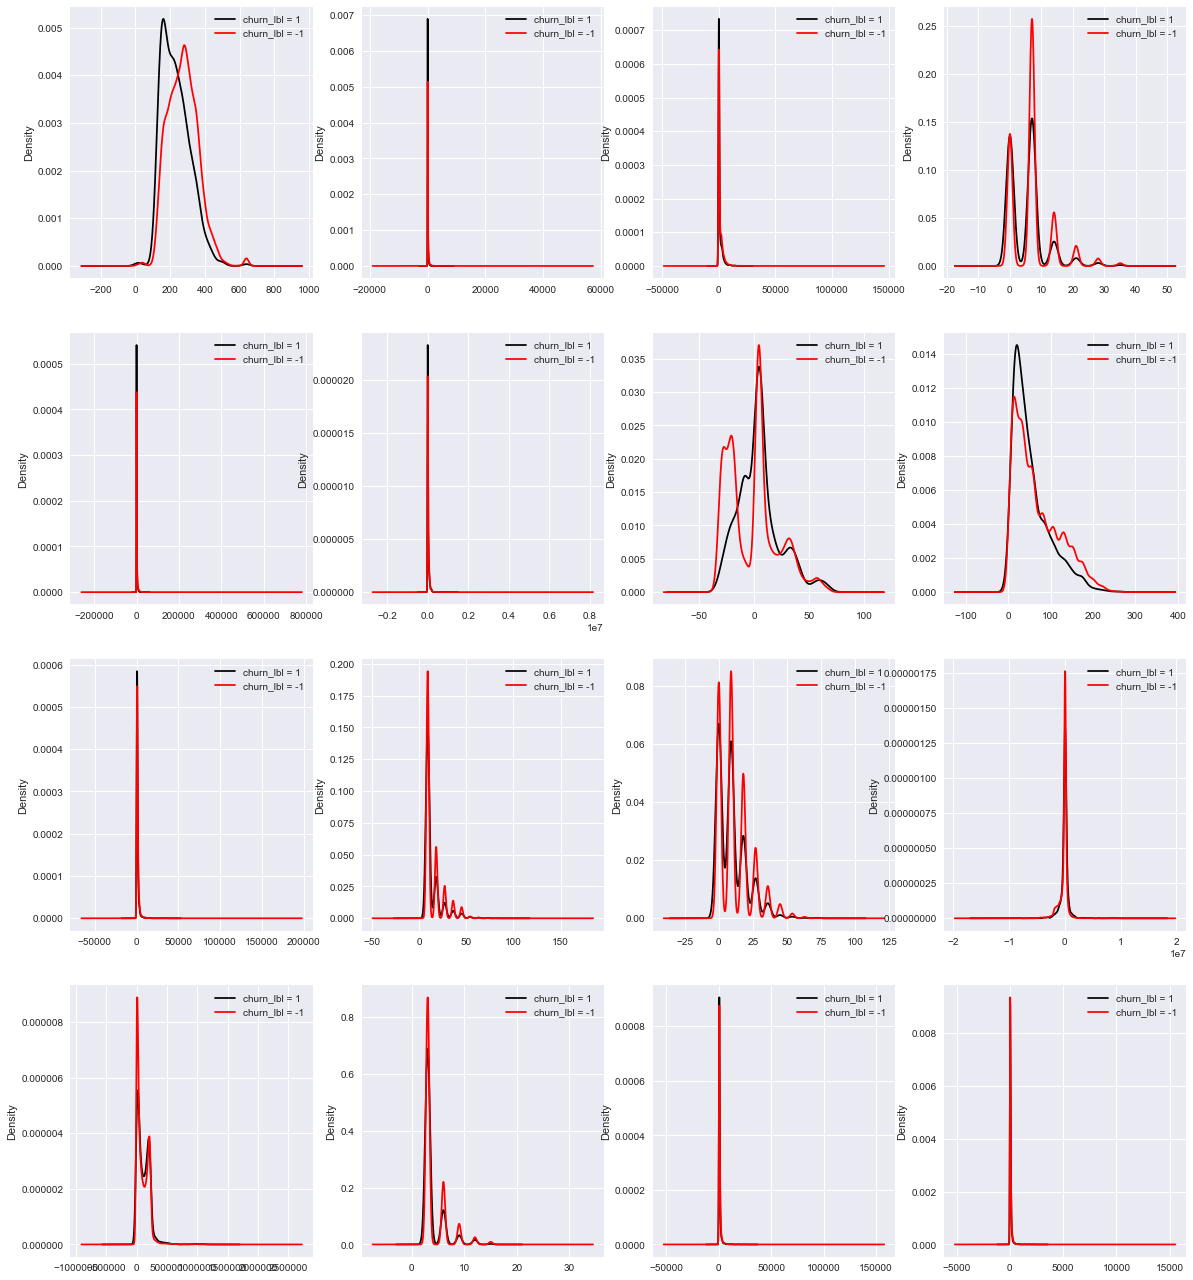

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 23))
for idx, feature in enumerate(train_data[result_numeric_features[:16]]):
    _ = train_data[feature][labels_data_train == 1].plot(kind="kde", color = 'black', ax=axes[idx // 4, idx % 4], label = 'churn_lbl = 1', legend=True)
    _ = train_data[feature][labels_data_train == -1].plot(kind="kde", color = 'red', ax=axes[idx // 4, idx % 4], label = 'churn_lbl = -1', legend=True)

Как дино из графика, отобранные по критерию вещественные признаки не имеют сущестенных отличий в разрезе классов. Посмотрим как выбранные признаки повлияют на качество будущей модели.

Сохраним датасет из наиболее значимых вещественных признаков для дальнейшего использования в построении модели.

In [12]:
numeric_data_selected_train = train_data[result_numeric_features].copy()
numeric_data_selected_test = test_data[result_numeric_features].copy()

#### Корреляция категориальных переменных

Рассчитаем меру взаимосвязи между каждым из категориальных признаков и целевой переменной (будем интерперетировать как категориальный признак с двумя значениями) с использованием коэффициента V Крамера. Не будем учитывать категориальные признаки с одним единственным значением признака,чтобы не получить нулевое значение в формуле для коэффициента V Крамера.

Значимость корреляции между категориальным признаком и целевой переменной проверим с использованием критерия Хи-квадрат.

Для расчета меры взаимосвязи категориальных признаков с целевой переменной заполним пропущенные значения категориальных признаков еще одной категорией `NA`.

In [13]:
categorial_dataset = train_data[categorial_features_data].copy()
categorial_dataset = categorial_dataset.fillna('NA').astype(str)
categorial_dataset.head()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NA,eOQt0GoOh3,RO12,NA,taul,1K8T,0Xwj,jZ0kHY6,h3WsUQk,xlN46Gq,...,oslk,TZoq6Bf,NA,NA,ELof,Qu4f,RAYp,F2FyR07IdsN7I,mj86,NA
1,NA,yaKt0Go8Lb,RO12,NA,taul,1K8T,lK27,a5zOfm0,daiGnRstPa,DlIsyEk,...,oslk,zccO8fW,jySVZNlOJy,NA,ELof,Qu4f,RAYp,F2FyR07IdsN7I,am7c,NA
2,NA,6m0t0G8rTN,RO12,NA,taul,1K8T,Uk76,cmPnuwV,k2w937Sptb8I4AR_,NA,...,oslk,_JxAGfT,LM8l689qOp,NA,NA,fKCe,RAYp,F2FyR07IdsN7I,NA,NA
3,NA,EsYq9aX0Db,RO12,NA,LfvqpCtLOY,1K8T,4fje,gRirkF8,UFIZdCX,NA,...,oslk,OTXAgOW,NA,NA,NA,uWr3,RAYp,F2FyR07IdsN7I,NA,NA
4,NA,6m0t0G8rTN,RO12,NA,taul,1K8T,lK27,B884X3H,k10MzgT,jhoTHnw,...,oslk,bTV7qqc,LM8l689qOp,NA,ELof,fKCe,RAYp,F2FyR07IdsN7I,NA,NA


In [14]:
def cramers_corr(conf_matr):
    chi2 = ss.chi2_contingency(conf_matr)[0]
    n = conf_matr.sum().sum()
    phi2 = chi2/n
    r,k = conf_matr.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [15]:
%%time
categorial_corr_list = []
for one_categiorial_column in categorial_dataset:
    one_categiorial_column = categorial_dataset[one_categiorial_column]
    number_of_categories = one_categiorial_column.unique()
    categorial_column_name = one_categiorial_column.name
    if len(number_of_categories) >= 2:
        confusion_matrix = pd.crosstab(labels_data_train, one_categiorial_column)
        p_val = ss.chi2_contingency(confusion_matrix)[1]
        categorial_corr_value = cramers_corr(confusion_matrix)
        categorial_corr_list.append((p_val, categorial_corr_value, categorial_column_name))

Wall time: 1min 3s
Compiler : 198 ms


In [16]:
categorial_corr_list = sorted(categorial_corr_list, reverse=True)
categorial_corr_list[:10]

[(1.0, 0.0, 'Var214'),
 (1.0, 0.0, 'Var200'),
 (0.9999999999974138, 0.0, 'Var217'),
 (0.9999979764948201, 0.0, 'Var222'),
 (0.9999979764948201, 0.0, 'Var220'),
 (0.9999979764948201, 0.0, 'Var198'),
 (0.9980185486932373, 0.0, 'Var202'),
 (0.48103480458416714, 0.0, 'Var215'),
 (0.4506146016280207, 0.0, 'Var196'),
 (0.42833938120957726, 0.0, 'Var203')]

In [17]:
result_categorial_features = [name[2] for name in categorial_corr_list if name[0] < 0.01]
len(result_categorial_features)

22

Воспользовавшись критерием  Хи - квадрат получили, что для 22 категориальных признаков была отвергнута нулевая гипотеза на уровне значимости 0.01, о том, что коэффицент V-Крамера для категориального признака равен 0. 

#### Сделаем визуализацию данных для категориальных признаков ( Для примера рассмотрим топ 16 из 22 категориальных признаков, наиболее сильно коррелирующих с целевой переменной и для этих переменных построим гистограммы значений категориальных признаков и отобразим их в координатах пар признаков).

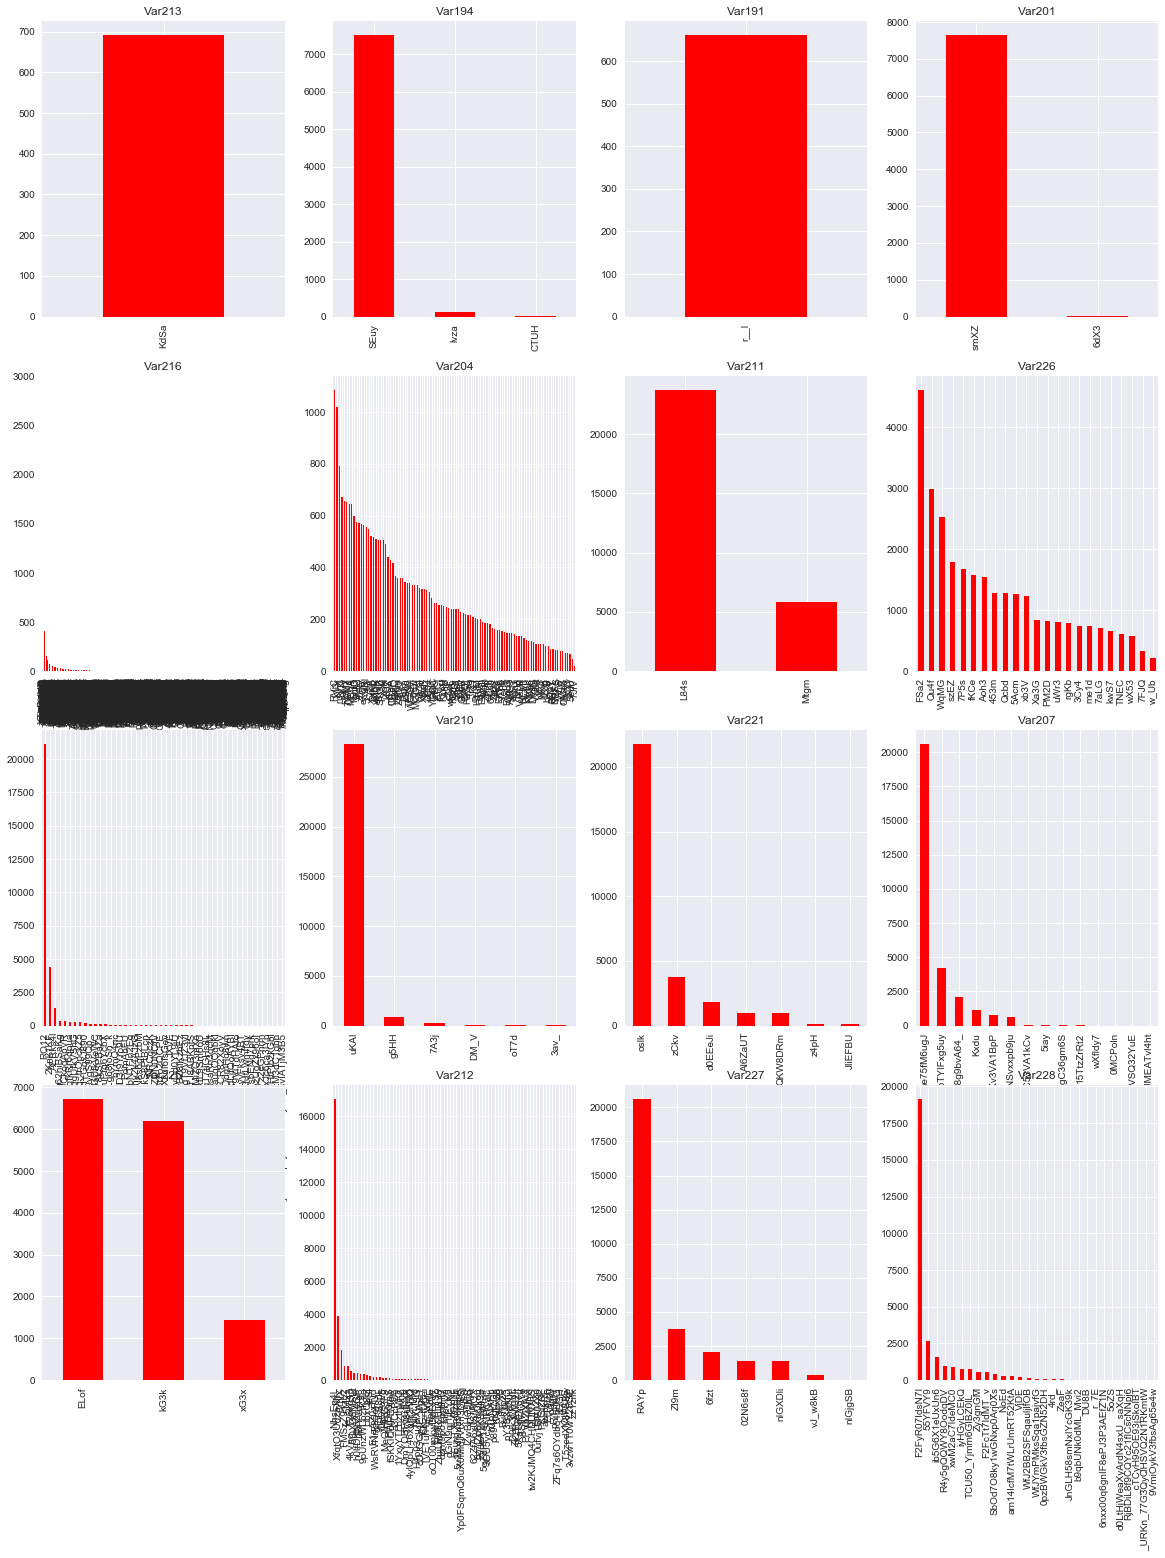

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 25))
for idx, feature in enumerate(train_data[result_categorial_features[:16]]):
    _ = train_data[feature][labels_data_train == 1].value_counts().plot(kind="bar", color = 'black', ax=axes[idx // 4, idx % 4], title=feature)
    _ = train_data[feature][labels_data_train == -1].value_counts().plot(kind="bar", color = 'red', ax=axes[idx // 4, idx % 4], title=feature)

Как видно из графика имеются категориальные признаки, как с большим количеством различных значений, так и с минимальным количеством вплоть до 1. В дальнейшем оценим, как выбранный набор признаков повлияет на качество модели.

Сохраним датасет из наиболее значимых категориальных признаков для дальнейшего использования в построении модели.

In [19]:
categorial_data_selected_train = train_data[result_categorial_features].copy()
categorial_data_selected_test = test_data[result_categorial_features].copy()

### 2.2. Подбор алгоритма, метрик качества, стратегии кросс - валидации.

#### Используемые метрики качества

В качестве основной метрики для решения задачи прогнозирования оттока будем использовать AUC ROC. Данная метрика не изменяется при изменении баланса классов и удобна для использования в случае несбалансированных классов( в задаче 93% пользователей принадлежат классу `не отток` и 7% классу `отток`).

В качестве вспомогательных метрик будем использовать стандартные метрики для задачи классификации: precision(точность) и recall (полнота).

#### Используемые алгоритмы классификации

Для решения задачи рассмотрим следующий набор алгоритмов:

- Линейная модель (реализация sklearn.linear_model.RidgeClassifier)
- Случайный лес (реализация sklearn.ensemble.RandomForestClassifier)
- Градиентный бустинг (реализация sklearn.ensemble.GradientBoostingClassifier)
- Градиентный бустинг (реализация xgboost.XGBClassifier)

#### Используемая стратегия кросс-валидации

В качестве стратегии кросс-валидации лучше всего подойдет StratifiedKFold, поскольку классы в нашей задаче несбалансированы и нам необходимо сохранить распределение классов при разбиении на фолды для того, чтобы избежать переобучения модели. Разделим выборку на 5 фолдов, поскольку данных у нас не очень много и скорость обучения моделей не будет большой на таком количестве данных.

### 2.3 Построение baseline-решения для задачи оттока.

Перед построением решения предварительно необходимо обработать пропущенные значения признаков и осуществить кодирование категориальных признаков для их использования в модели. Различны методы обработки признаков и их влияние на качество модели рассмотрим далее, а для построения baseline - решения осуществим следующий формат обработки признаков:
- вещественные (заменим пропущенные значения на 0, данный признак давать вклад в модель не будет);
- категориальные (заменим пропущенные значения еще одной категорией(например 'NA'), в этом случае мы не потеряем информацию о наличии пропущенных значений). Закодируем категориальные признаки с использованием метода LabelEncoder;
- сбалансируем объекты по классам с использованием метода oversampling (добавим объектов из класса `отток`, чтобы выровнять соотношение классов).

Построим модель на отобранных ранее признаках (всего получилось 50 признаков: 28 вещественных и 22 категориальных).

In [20]:
baseline_selected_data = pd.concat([numeric_data_selected_train, categorial_data_selected_train],axis=1)
baseline_selected_data.shape

(32000, 50)

Удалим из данных неинформативные признаки в которых количество различных значений меньше 3.

In [66]:
def drop_uninformative_features(dataset):
    for one_column in dataset.columns:
        if dataset.loc[:,str(one_column)].unique().shape[0] < 3:
            dataset.drop(columns=str(one_column), inplace=True)
    return dataset

In [67]:
baseline_selected_data = drop_uninformative_features(baseline_selected_data)
baseline_selected_data.shape

(32000, 47)

Целевая переменная.

In [21]:
labels_data_train.shape

(32000,)

Поскольку в нашей задаче классы несбалансированы, то воспользуемся методом Oversampling и сделаем количество объектов в классе `отток`, равным количеству объектов в классе `не отток`.

In [25]:
baseline_selected_data_for_oversample = pd.concat([baseline_selected_data, labels_data_train], axis=1)
baseline_selected_data_for_oversample.shape

(32000, 51)

In [26]:
def oversampling(data):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    alpha = (int)(dataNoChurn.shape[0]/dataChurn.shape[0])
    dataChurnRet = dataChurn 
    for i in range(alpha):
        dataChurnRet = dataChurnRet.append(dataChurn)
    dataNoChurn = dataNoChurn.append(dataChurnRet)
    dataNoChurn = shuffle(dataNoChurn)
    return dataNoChurn.iloc[:,:data.shape[1]-1], dataNoChurn.iloc[:,data.shape[1]-1:]
def undersampling(data):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    countFirst = len(dataChurn)
    dataChurn = dataChurn.append(dataNoChurn.iloc[:countFirst,:])
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:data.shape[1]-1], dataChurn.iloc[:,data.shape[1]-1:]

In [27]:
baseline_selected_oversample, label_baseline_oversample = oversampling(baseline_selected_data_for_oversample)

In [28]:
baseline_selected_oversample.shape

(60572, 50)

Обработаем пропущенные значения вещественных признаков.

In [29]:
baseline_selected_numeric_features_data = baseline_selected_oversample.iloc[:,:28]
baseline_selected_numeric_features_data.fillna(0, inplace=True)
baseline_selected_numeric_features_data.head()

,Var189,Var74,Var13,Var7,Var140,Var125,Var126,Var73,Var6,Var65,...,Var22,Var25,Var28,Var85,Var188,Var94,Var24,Var109,Var38,Var53
4569,312.0,210.0,400.0,14.0,3320.0,71163.0,0.0,134.0,952.0,18.0,...,145.0,40.0,200.00,6.0,0.0,114741.0,0.0,24.0,7257600.0,0.0
10087,0.0,28.0,108.0,7.0,580.0,3348.0,-10.0,58.0,518.0,9.0,...,275.0,32.0,235.60,38.0,0.0,24576.0,2.0,40.0,5512248.0,0.0
16963,156.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,616.0,9.0,...,530.0,264.0,288.08,18.0,0.0,30177.0,8.0,88.0,6833340.0,0.0
27588,0.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,252.0,18.0,...,485.0,232.0,241.68,10.0,0.0,374832.0,6.0,80.0,1441986.0,0.0
27041,162.0,0.0,40.0,0.0,0.0,16524.0,0.0,156.0,91.0,9.0,...,0.0,0.0,233.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обработаем пропущенные значения категориальных признаков.

In [30]:
baseline_selected_categorial_features_data = baseline_selected_oversample.iloc[:,28:]
baseline_selected_categorial_features_data = baseline_selected_categorial_features_data.fillna('NA').astype(str)
baseline_selected_categorial_features_data.head()

,Var213,Var194,Var191,Var201,Var216,Var204,Var211,Var226,Var193,Var210,...,Var225,Var212,Var227,Var228,Var229,Var205,Var206,Var192,Var199,Var218
4569,NA,SEuy,NA,smXZ,beK4AFX,Px52,L84s,PM2D,2Knk1KF,uKAI,...,xG3x,NhsEn4L,RAYp,55YFVY9,NA,VpdQ,sYC_,4e7Wq69R_D,II0CMuA,UYBR
10087,NA,NA,NA,NA,XTbPUYD,LqKm,Mtgm,453m,RO12,uKAI,...,NA,XfqtO3UdzaXh_,RAYp,F2FyR07IdsN7I,NA,09_Q,kxE9,vAsgUHXM47,nQUeejKKqM,cJvF
16963,NA,NA,NA,NA,kq00nJM,15m3,L84s,FSa2,RO12,uKAI,...,NA,NhsEn4L,RAYp,F2FyR07IdsN7I,NA,sJzTlal,zm5i,639qrQK2Mx,HKFGqS8,UYBR
27588,NA,NA,NA,NA,TDc_9Yi,kJJ7,L84s,7P5s,AERks4l,uKAI,...,NA,JBfYVit4g8,02N6s8f,xwM2aC7IdeMC0,NA,09_Q,IYzP,dRaq9ayE15,mzDZadGIEhIBI,cJvF
27041,NA,SEuy,NA,smXZ,OFqmdNV,Y9Bl,L84s,uWr3,2Knk1KF,uKAI,...,kG3k,XfqtO3UdzaXh_,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c,sJzTlal,haYg,JMGq9aXt5a,GHf4lBZm_z,cJvF


Преобразуем значения категориальных признаков с использованием метода preprocessing.LabelEncoder.

In [22]:
def labelEncoder(data):
    lab_enc = LabelEncoder()
    for one_column in data.columns:
        lab_enc.fit(data.loc[:,one_column])
        data.loc[:,one_column] = lab_enc.transform(data.loc[:,one_column])        
    return data

In [32]:
encoded_base_selected_categorial_data = labelEncoder(baseline_selected_categorial_features_data)

Объединим обработанные признаки в один датасет для их дальнейшего отбора.

In [33]:
result_base_selected_data_for_model = pd.concat([baseline_selected_numeric_features_data, encoded_base_selected_categorial_data], axis=1)
result_base_selected_data_for_model.shape

(60572, 50)

#### Кросс-валидация (Для кросс - валидации используем StratifiedKFold с разбиением на 5 фолдов, для тестовой выборки оставим 20% данных).

Создадим обучающую, а также отложенную выборку для проверки качества модели.

In [34]:
select_train_data_for_model, select_test_data_for_model, select_train_labels_for_model, select_test_labels_for_model = train_test_split(result_base_selected_data_for_model, label_baseline_oversample, test_size=0.20, random_state=5, stratify = label_baseline_oversample)

In [35]:
select_train_data_for_model.shape
select_test_data_for_model.shape
select_train_labels_for_model.shape
select_test_labels_for_model.shape

(48457, 50)

(12115, 50)

(48457, 1)

(12115, 1)

Зададим стратегию кросс-валидации с разбиением на 5 фолдов.

In [36]:
cross_val_strategy = StratifiedKFold(n_splits=5, random_state=100)

#### Построение модели для baseline - решения.

Построим модели и посчитаем их метрики на кросс-валидации.
В качестве основной метрики для решения задачи прогнозирования оттока будем использовать AUC ROC.
В качестве вспомогательных метрик будем использовать стандартные метрики для задачи классификации: precision(точность) и recall (полнота).
Также выведем метрики PR-AUC, f1-score и Accuracy.


Будем использовать следующие модели: 
- Линейная модель (RidgeClassifier);
- Случайный лес (RandomForestClassifier);
- Градиентный бустинг (GradientBoostingClassifier);
- Градиентный бустинг (XGBClassifier).

Напишем функцию для подсчета и отображения метрик при построении и обучении модели

In [23]:
def calculate_classification_metrics(classif, strategy, train_dat, train_lab):
    roc_auc = []
    pr_auc = []
    accuracy = []
    precision = []
    recall = []
    f1_score = []
    roc_auc.append(cross_val_score(classif, train_dat, train_lab, scoring='roc_auc', cv= strategy))
    pr_auc.append(cross_val_score(classif, train_dat, train_lab, scoring='average_precision', cv= strategy))
    accuracy.append(cross_val_score(classif, train_dat, train_lab, scoring='accuracy', cv= strategy))
    precision.append(cross_val_score(classif, train_dat, train_lab, scoring='precision', cv= strategy))
    recall.append(cross_val_score(classif, train_dat, train_lab, scoring='recall', cv= strategy))
    f1_score.append(cross_val_score(classif, train_dat, train_lab, scoring='f1', cv= strategy))

    print ('ROC-AUC: {}'.format(np.mean(roc_auc)))
    print ('PR-AUC: {}'.format(np.mean(pr_auc)))
    print ('Accuracy: {}'.format(np.mean(accuracy)))
    print ('Precision: {}'.format(np.mean(precision)))
    print ('Recall: {}'.format(np.mean(recall)))
    print ('F1-score: {}'.format(np.mean(f1_score)))
    
    return roc_auc, pr_auc, accuracy, precision, recall, f1_score

#### RidgeClassifier

Обучим линейную модель RidgeClassifier с параметрами по умолчанию. 

In [99]:
%%time
ridg_classif = RidgeClassifier(random_state=10)
roc_auc, pr_auc, accuracy, precision, recall, f1_score = calculate_classification_metrics(ridg_classif, cross_val_strategy, select_train_data_for_model, select_train_labels_for_model)

ROC-AUC: 0.6699904695826435
PR-AUC: 0.6658287391081849
Accuracy: 0.6241823161101051
Precision: 0.6217452061592071
Recall: 0.6757124889959154
F1-score: 0.6475678574314254
Wall time: 6.87 s


Проверим качество модели на тестовой выборке.

In [100]:
%%time
ridg_classif = RidgeClassifier(random_state=10)
roc_auc, pr_auc, accuracy, precision, recall, f1_score = calculate_classification_metrics(ridg_classif, cross_val_strategy, select_test_data_for_model, select_test_labels_for_model)

ROC-AUC: 0.6665038146932147
PR-AUC: 0.6590491053045536
Accuracy: 0.6202228642179117
Precision: 0.6187213752177425
Recall: 0.6691964570938312
F1-score: 0.6429322080348212
Wall time: 2.27 s


#### RandomForestClassifier

Обучим случайный лес RandomForestClassifier с параметрами по умолчанию. 

In [101]:
%%time
rand_forest_classif = RandomForestClassifier(random_state=19)
roc_auc, pr_auc, accuracy, precision, recall, f1_score = calculate_classification_metrics(rand_forest_classif, cross_val_strategy, select_train_data_for_model, select_train_labels_for_model)

ROC-AUC: 0.9999999147930619
PR-AUC: 0.9999999184514616
Accuracy: 0.9959758263737861
Precision: 0.9921885366026568
Recall: 1.0
F1-score: 0.9960784698573691
Wall time: 16min 46s


Проверим качество модели на тестовой выборке.

In [102]:
%%time
rand_forest_classif = RandomForestClassifier(random_state=19)
roc_auc, pr_auc, accuracy, precision, recall, f1_score = calculate_classification_metrics(rand_forest_classif, cross_val_strategy, select_test_data_for_model, select_test_labels_for_model)

ROC-AUC: 0.9612239360313612
PR-AUC: 0.972593326090912
Accuracy: 0.8939331407346266
Precision: 0.8813231951599885
Recall: 0.9158454170529415
F1-score: 0.8982196564938956
Wall time: 3min 16s


Модель, основанная на случайном лесе переобучилась на имеющейся выборке.

#### GradientBoostingClassifier

Обучим градиентный бустинг GradientBoostingClassifier с параметрами по умолчанию. 

In [103]:
%%time
grad_boost_classif = GradientBoostingClassifier(random_state=23)
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(grad_boost_classif, cross_val_strategy, select_train_data_for_model, select_train_labels_for_model)

ROC-AUC: 0.7839289676468557
PR-AUC: 0.7755090142767267
Accuracy: 0.704686724449118
Precision: 0.6968874019719921
Recall: 0.7470719594560435
F1-score: 0.721086137358441
Wall time: 21min 1s


Проверим качество модели на тестовой выборке.

In [104]:
%%time
grad_boost_classif = GradientBoostingClassifier(random_state=23)
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(grad_boost_classif, cross_val_strategy, select_test_data_for_model, select_test_labels_for_model)

ROC-AUC: 0.7765656495586754
PR-AUC: 0.7724775111888922
Accuracy: 0.7006190672719768
Precision: 0.690595505664907
Recall: 0.7504456014217522
F1-score: 0.7192509699981555
Wall time: 4min 38s


#### XGBClassifier

Обучим градиентный бустинг XGBClassifier с параметрами по умолчанию.

In [105]:
%%time
xgboost_classifier = xgb.XGBClassifier(random_state=44, n_jobs=-1)
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgboost_classifier, cross_val_strategy, select_train_data_for_model, select_train_labels_for_model)

ROC-AUC: 0.7820539770364382
PR-AUC: 0.7733467238921349
Accuracy: 0.7045422477373797
Precision: 0.6957235421771125
Recall: 0.7497778716053684
F1-score: 0.7217116700138766
Wall time: 3min 24s


Проверим качество модели на тестовой выборке.

In [106]:
%%time
xgboost_classifier = xgb.XGBClassifier(random_state=44, n_jobs=-1)
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgboost_classifier, cross_val_strategy, select_test_data_for_model, select_test_labels_for_model)

ROC-AUC: 0.7757823982062518
PR-AUC: 0.771003500249593
Accuracy: 0.7021873710276517
Precision: 0.6908503725637836
Recall: 0.7551301860247399
F1-score: 0.7215485392943257
Wall time: 54.3 s


В baseline - решении были обучены следующие 4 модели: 
- Линейная модель. Для нее получились следующие значения метрик на кросс-валидации: (ROC-AUC: 0.67, Precision: 0.62, Recall: 0.67)
- Случайный лес. Для нее получились следующие значения метрик на кросс-валидации: (ROC-AUC: 0.96, Precision: 0.88, Recall: 0.91)
- Градиентный бустинг (sklearn). Для нее получились следующие значения метрик на кросс-валидации: (ROC-AUC: 0.78, Precision: 0.69, Recall: 0.75)
- Градиентный бустинг (xgboost). Для нее получились следующие значения метрик на кросс-валидации: (ROC-AUC: 0.78, Precision: 0.69, Recall: 0.75)

Наилучшее качество показала модель на основе случайного леса (видно, что модель очень сильно подстроилась под имеющиеся данные и переобучилась). 
Хорошее качество показали модели градиентного бустинга из пакетов sklearn и xgboost, но в дальнейшем для построения модели выберем реализацию градиентного бустинга из пакета xgboost, поскольку эта реализация алгоритма градиентного бустинга имеет большое количество параметров для настройки.

## 3. Эксперименты с моделью.

### 3.1. Построение кривых обучения.

Для начала оценим как много объектов нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Построим кривые обучения с использованием метода `sklearn.model_selection.learning_curve`. Будем обучать модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом.

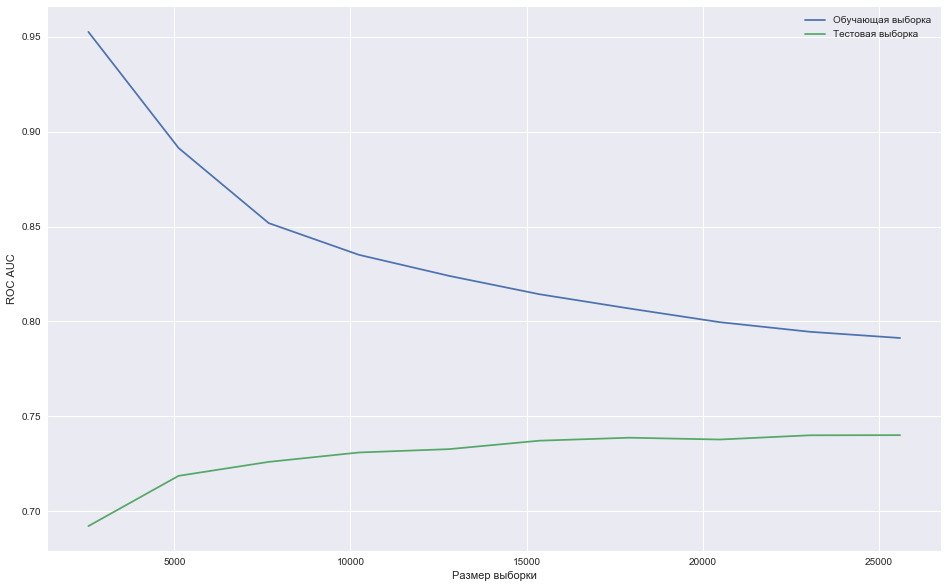

In [38]:
numeric_data_first = numeric_data_selected_train.copy()
categorial_data_first = categorial_data_selected_train.copy()
# обработаем отдельно вещественые признаки
# удалим пустые значения столбцов
numeric_data_first = numeric_data_first.dropna(axis=1,how='all')
# заменяем пропущенные значения  вещественных признаков средними значенияи по столбцу
numeric_data_first = numeric_data_first.fillna(numeric_data_first.mean())
# отмасштабируем значения вещественных признаков
numeric_data_first = pd.DataFrame(StandardScaler().fit_transform(numeric_data_first))
# обработаем отдельно категориальные признаки
categorial_data_first = categorial_data_first.fillna('NA').astype(str)
categorial_data_first_encoded = categorial_data_first.apply(LabelEncoder().fit_transform)
# объединим категориальные и вещественные признаки в один датасет
train_data_first = pd.DataFrame(np.hstack((numeric_data_first,categorial_data_first_encoded)))


train_sizes, train_scores, test_scores = learning_curve(xgb.XGBClassifier(random_state=44, n_jobs=-1), train_data_first, labels_data_train, cv=5, scoring='roc_auc',
                                                       train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.figure(figsize=(16,10))
plt.plot(train_sizes, train_scores.mean(axis=1), label=u'Обучающая выборка')
plt.plot(train_sizes, test_scores.mean(axis=1), label=u'Тестовая выборка')
plt.xlabel(u'Размер выборки')
plt.ylabel(u'ROC AUC')
plt.legend(loc='best')
plt.show()

По графику видно, что метрика `ROC-AUC` растет на тестовой выборке с увеличением объема обучающей выборки до определенного момента. После метрика качество выходит на постоянный уровень на обучающей и тестовой выборке. Это говорит нам о том, что выборка порядка 20-25 тысяч объектов (или наша выборка размером в 32 тыс. объектов) вполне достаточна для построения модели с максимально возможным качеством.

### 3.2. Балансировка выборки по классам.

Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Для решения этой проблемы попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

#### Задание весов объектам выборки.

Для задания весов объектов будем использовать параметр sample_weight в модели классификации XGBClassifier.

Используем определенную ранее функцию calculate_classification_metrics для подсчета и отображения метрик качества классификации.

Зададим стратегию кросс-валидации с разбиением на 5 фолдов.

In [26]:
cross_val_strategy_weight = StratifiedKFold(n_splits=5, random_state=55)

По посчитанным ранее данным положительный класс составляет 7.4%, отрицательный 92.6% (соотношение отрицательного и положительного классов составляет 13:1). На основании этих данных сделаем 3 варианта задания весов объектам для получения разного соотношения классов.

In [40]:
%%time
# 1 вариант соотношение отрицательного и положительного класса 3 к 1.
weight_objects = {-1: 3, 1: 1}
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, sample_weight=weight_objects, n_jobs=-1), cross_val_strategy_weight, train_data_first, labels_data_train)

ROC-AUC: 0.7401485238573005
PR-AUC: 0.218097532291864
Accuracy: 0.9258124999999999
Precision: 0.597121212121212
Recall: 0.010497154836777479
F1-score: 0.02061390697393608
Wall time: 3min 18s


In [41]:
%%time
# 2 вариант соотношения отрицательного и положительного класса равны.
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, sample_weight=weight_objects, n_jobs=-1), cross_val_strategy_weight, train_data_first, labels_data_train)

ROC-AUC: 0.7401485238573005
PR-AUC: 0.218097532291864
Accuracy: 0.9258124999999999
Precision: 0.597121212121212
Recall: 0.010497154836777479
F1-score: 0.02061390697393608
Wall time: 2min 49s


In [127]:
%%time
# 3 вариант соотношение отрицательного и положительного класса 1 к 5.
weight_objects = {-1: 1, 1: 5}
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, sample_weight=weight_objects, n_jobs=-1), cross_val_strategy_weight, train_data_first, labels_data_train)

ROC-AUC: 0.7401485238573005
PR-AUC: 0.218097532291864
Accuracy: 0.9258124999999999
Precision: 0.597121212121212
Recall: 0.010497154836777479
F1-score: 0.02061390697393608
Wall time: 2min 45s


Изменение весов объектов не влияет на изменение метрик для модели XGBClassifier.

#### Undersampling и Oversampling.

Применим к нашей выборке технологию undersampling: для этого уберем из обучения некоторое количество объектов класса `не отток`, таким образом, чтобы соотношение классов изменилось.

Посичтаем соотношение класса `отток` и `не отток` и разделим объекты классов по индексам.

In [96]:
idx_negative = train_data_first[labels_data_train == 1].index.tolist()
idx_positive = train_data_first[labels_data_train == -1].index.tolist()
len(idx_negative)
len(idx_positive)

2381

29619

Вариант 1. Сделаем количество объектов класса `отток` в 2 раза меньше количества объектов класса `не отток`.

In [100]:
case_1_sample = list(np.random.choice(idx_negative, len(idx_positive)//2))
len(case_1_sample)

14809

In [101]:
%%time
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        train_data_first.ix[case_1_sample+idx_positive],
                                                                                        labels_data_train[case_1_sample+idx_positive])

ROC-AUC: 0.7853130400666782
PR-AUC: 0.6360558737271287
Accuracy: 0.7369225597643939
Precision: 0.6831060406452494
Recall: 0.39293630612319824
F1-score: 0.49883118193057996
Wall time: 3min 10s


Вариант 2. Сделаем равное количество объектов класса `не отток` и объектов класса `отток`.

In [91]:
case_2_sample = list(np.random.choice(idx_negative, len(idx_positive)))
len(case_2_sample)

29619

In [92]:
%%time
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        train_data_first.ix[case_2_sample+idx_positive],
                                                                                        labels_data_train[case_2_sample+idx_positive])

ROC-AUC: 0.7860615300764511
PR-AUC: 0.7691911558506813
Accuracy: 0.7083290957570834
Precision: 0.698487247511876
Recall: 0.7331781609201954
F1-score: 0.7154043566695545
Wall time: 4min 19s


Вариант 3. Сделаем количество объектов класса `отток` в 1,5 раза больше количества объектов класса `не отток`.

In [108]:
case_3_sample = list(np.random.choice(idx_negative, int(1.5*len(idx_positive))))
len(case_3_sample)

44428

In [109]:
%%time
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        train_data_first.ix[case_3_sample+idx_positive],
                                                                                        labels_data_train[case_3_sample+idx_positive])

ROC-AUC: 0.7876056793859296
PR-AUC: 0.8310291785591011
Accuracy: 0.726551987725405
Precision: 0.7259950625425818
Recall: 0.8742459498549184
F1-score: 0.7932456694100689
Wall time: 5min 11s


Балансировка классов не оказыает существенное влияние на метрику ROC-AUC (что известно из определения метрики ROC-AUC). Зато баланс классов существенно изменяет значения метрик `точность (precision)` и `полнота (recall)`. Налиучший результат показал случай, когда представителей класса `отток` в 1,5 раза больше, чем  в классе `не отток` (исходное соотношение классов в выборке 13:1).

### 3.3. Выбор стратегии обработки вещественных признаков.

Рассмотрим несколько стратегий для обработки пропущенных значений признаков. Сравним эти стратегии между собой с помощью оценки качества моделей на кросс-валидации, построенных на датасетах с использованием различных стратегий.

Поработаем отдельно с вещественными признаками и найдем лучшую стратегию с помощью оценки качества моделей по кросс-валидации.

In [31]:
numeric_data_3_task = numeric_data_selected_train.copy()
# удалим пустые значения столбцов
numeric_data_3_task = numeric_data_3_task.dropna(axis=1,how='all')

Вариант 1. Заполним пропущенные значения вещественных признаков средними значениями по столбцу.

In [32]:
%%time
# заменяем пропущенные значения  вещественных признаков нулями
numeric_data_3_task_mean = numeric_data_3_task.fillna(0)
# заменяем пропущенные значения  вещественных признаков средними значенияи по столбцу
numeric_data_3_task_mean = numeric_data_3_task_mean.fillna(numeric_data_3_task_mean.mean())
# отмасштабируем значения вещественных признаков
numeric_data_3_task_mean = pd.DataFrame(StandardScaler().fit_transform(numeric_data_3_task_mean))
# посчитаем значения метрик с использованием модели логистической регрессии.
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        numeric_data_3_task_mean, 
                                                                                        labels_data_train)

ROC-AUC: 0.7223471412811654
PR-AUC: 0.1966720366619307
Accuracy: 0.9259999999999999
Precision: 0.75
Recall: 0.005879710374715924
F1-score: 0.011663223364684745
Wall time: 1min 42s


Вариант 2. Заполним пропущенные значения вещественных признаков нулевыми значениями.

In [54]:
%%time
# заменяем пропущенные значения  вещественных признаков нулями
numeric_data_3_task_null = numeric_data_3_task.fillna(0)
# отмасштабируем значения вещественных признаков
numeric_data_3_task_null = pd.DataFrame(StandardScaler().fit_transform(numeric_data_3_task_null))
# посчитаем значения метрик с использованием модели логистической регрессии.
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        numeric_data_3_task_null, 
                                                                                        labels_data_train)

ROC-AUC: 0.7223471412811654
PR-AUC: 0.1966720366619307
Accuracy: 0.9259999999999999
Precision: 0.75
Recall: 0.005879710374715924
F1-score: 0.011663223364684745
Wall time: 1min 47s


Вариант 3. Заполним пропущенные значения вещественных признаков медианными значениями.

In [33]:
%%time
# заменяем пропущенные значения  вещественных признаков нулями
numeric_data_3_task_median = numeric_data_3_task.fillna(0)
# заменяем пропущенные значения  вещественных признаков средними значениями по столбцу
numeric_data_3_task_median = numeric_data_3_task_median.fillna(numeric_data_3_task_median.median())
# отмасштабируем значения вещественных признаков
numeric_data_3_task_median = pd.DataFrame(StandardScaler().fit_transform(numeric_data_3_task_median))
# посчитаем значения метрик с использованием модели логистической регрессии.
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        numeric_data_3_task_median, 
                                                                                        labels_data_train)

ROC-AUC: 0.7223471412811654
PR-AUC: 0.1966720366619307
Accuracy: 0.9259999999999999
Precision: 0.75
Recall: 0.005879710374715924
F1-score: 0.011663223364684745
Wall time: 1min 39s


Рассмотренные варианты заполнения пропущенных значений вещественных признаков не оказывают влияния на качество модели, поэтому можно выбрать любой из рассмотренных вариантов. Выберем заполнение пропущенных значений вещественных признаков медианами по столбцу.

### 3.4. Выбор стратегии обработки категориальных признаков.

4\. Рассмотрим несколько стратегий для обработки категориальных признаков. Сравним эти стратегии между собой с помощью оценки качества моделей по кросс-валидации.

Поработаем отдельно с категориальными признаками и найдем лучшую стратегию с помощью оценки качества моделей по кросс-валидации.

In [34]:
categorial_data_first = categorial_data_selected_train.copy()

Вариант 1. Рассмотрим dummy-кодирование на тех признаках, которые имеют не слишком много уникальных значений (не более 300 значений).

In [28]:
# обработаем категории
categorial_data_first_dummy_select = categorial_data_first.dropna(axis=1,how='all').copy()
# заменяем пропущенные значения  категориальных признаков еще обной категорие (так мы не потеряем информацию о признаках)
categorial_data_first_dummy_select = categorial_data_first_dummy_select.fillna('NA').astype(str)
# посчитаем количество уникальных значений и отберем те, где меньше 300 уникальных
counts_of_different_value = pd.Series([len(categorial_data_first_dummy_select[categorial_data_first_dummy_select.columns[i]].value_counts()) 
                    for i in range(len(categorial_data_first_dummy_select.columns))], 
                   index = categorial_data_first_dummy_select.columns)
vars_for_select_dummy = counts_of_different_value[counts_of_different_value <300].index
# составим дамми переменные
dummy_features_300 = pd.get_dummies(categorial_data_first_dummy_select[vars_for_select_dummy])
# уберем дубликаты
dummy_features_300 = dummy_features_300.T.drop_duplicates().T

In [29]:
dummy_features_300.shape

(32000, 360)

In [60]:
%%time
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        pd.concat([numeric_data_3_task_median,dummy_features_300], axis=1), 
                                                                                        labels_data_train)

ROC-AUC: 0.7389729972307457
PR-AUC: 0.22464177392207946
Accuracy: 0.92596875
Precision: 0.725
Recall: 0.011339252682204957
F1-score: 0.02226402088940517
Wall time: 13min 20s


Вариант 2. Рассмотрим dummy-кодирование на тех признаках, которые имеют до 600 уникальных значений.

In [61]:
# обработаем категории
categorial_data_first_dummy_select = categorial_data_first.dropna(axis=1,how='all').copy()
# заменяем пропущенные значения  категориальных признаков еще обной категорие (так мы не потеряем информацию о признаках)
categorial_data_first_dummy_select = categorial_data_first_dummy_select.fillna('NA').astype(str)
# посчитаем количество уникальных значений и отберем те, где меньше 600 уникальных
counts_of_different_value = pd.Series([len(categorial_data_first_dummy_select[categorial_data_first_dummy_select.columns[i]].value_counts()) 
                    for i in range(len(categorial_data_first_dummy_select.columns))], 
                   index = categorial_data_first_dummy_select.columns)
vars_for_select_dummy = counts_of_different_value[counts_of_different_value <600].index
# составим дамми переменные
dummy_features_600 = pd.get_dummies(categorial_data_first_dummy_select[vars_for_select_dummy])
# уберем дубликаты
dummy_features_600 = dummy_features_600.T.drop_duplicates().T

In [62]:
dummy_features_600.shape

(32000, 706)

In [64]:
%%time
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        pd.concat([numeric_data_3_task_median,dummy_features_600], 
                                                                                                  axis=1), 
                                                                                        labels_data_train)

ROC-AUC: 0.7392934378680174
PR-AUC: 0.22467831540376304
Accuracy: 0.92609375
Precision: 0.7428571428571429
Recall: 0.011758539893945002
F1-score: 0.023122250975619145
Wall time: 24min 23s


Вариант 3. Рассмотрим LabelEncoder кодирование на всех категориальных признаках, за исключением тех, которые имеют все пропущенные значения.

In [35]:
categorial_data_label_enc = categorial_data_first.dropna(axis=1,how='all').copy()
categorial_data_label_enc = categorial_data_label_enc.fillna('NA').astype(str)
categorial_data_label_enc = labelEncoder(categorial_data_label_enc) 

In [36]:
%%time
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        pd.concat([numeric_data_3_task_median,categorial_data_label_enc], 
                                                                                                  axis=1), 
                                                                                        labels_data_train)

ROC-AUC: 0.7368132196801762
PR-AUC: 0.2201262406204723
Accuracy: 0.92590625
Precision: 0.6544444444444444
Recall: 0.011337490971231259
F1-score: 0.022246660983632767
Wall time: 2min 42s


Наилучшее качество получилось с dummy - переменными для категориальных признаков с небольшим количеством значений, но если мы будем обобщать данный метод обработки признаков на данные для обучения и тестовые данные, то можем получить ситуацию с различным количеством обработанных категориальных признаков для обучения и теста. Поэтому оптимальным вариантом будет использовать метод LabelEncoder для обработки пропущенных признаков. 

### 3.5. Подберем оптимальные параметры для выбранной модели XGBClassifier.

В зависимости от того, как мы обрабатываем исходные данные, делаем ли балансировку классов, сколько объектов оставляем в обучающей выборке оптимальные значения параметров могут меняться. Возьмем наилучшее из имеющихся решений на текущий момент и проведите процедуру подбора параметров модели с использованием `sklearn.model_selection.GridSearchCV`.

В качестве признаков возьмем наиболее коррелирующие признаки из пункта 1.

In [58]:
numeric_data_selected_train.head()
categorial_data_selected_train.head()

,Var189,Var74,Var13,Var7,Var140,Var125,Var126,Var73,Var6,Var65,...,Var22,Var25,Var28,Var85,Var188,Var94,Var24,Var109,Var38,Var53
0,0.0,0.0,0.0,0.0,0.0,4923.0,0.0,48.0,168.0,9.0,...,120.0,96.0,133.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,318.0,182.0,820.0,7.0,5500.0,4869.0,-24.0,86.0,1155.0,18.0,...,380.0,48.0,253.52,0.0,0.0,253872.0,0.0,8.0,2740026.0,0.0
2,156.0,14.0,4.0,7.0,45.0,171.0,-28.0,32.0,686.0,9.0,...,170.0,64.0,253.52,6.0,0.0,1374.0,4.0,32.0,2858460.0,0.0
3,0.0,238.0,300.0,7.0,265.0,8001.0,0.0,42.0,798.0,9.0,...,170.0,32.0,186.64,4.0,0.0,0.0,2.0,32.0,6336420.0,0.0
4,360.0,49.0,1080.0,7.0,9455.0,551979.0,32.0,56.0,3108.0,9.0,...,510.0,280.0,233.44,34.0,0.0,447552.0,12.0,144.0,0.0,0.0


,Var213,Var194,Var191,Var201,Var216,Var204,Var211,Var226,Var193,Var210,...,Var225,Var212,Var227,Var228,Var229,Var205,Var206,Var192,Var199,Var218
0,NaN,NaN,NaN,NaN,TDcECyH,t_4G,L84s,Qu4f,RO12,uKAI,...,ELof,NhsEn4L,RAYp,F2FyR07IdsN7I,mj86,VpdQ,IYzP,eOQt0GoOh3,h3WsUQk,cJvF
1,NaN,NaN,NaN,NaN,XTbPUYD,rGJy,Mtgm,Qu4f,RO12,uKAI,...,ELof,XfqtO3UdzaXh_,RAYp,F2FyR07IdsN7I,am7c,09_Q,lVqb,yaKt0Go8Lb,daiGnRstPa,UYBR
2,NaN,NaN,NaN,NaN,NGZXfGp,k13i,L84s,fKCe,RO12,uKAI,...,NaN,NhsEn4L,RAYp,F2FyR07IdsN7I,NaN,sJzTlal,zm5i,6m0t0G8rTN,k2w937Sptb8I4AR_,cJvF
3,NaN,NaN,NaN,NaN,mAja5EA,Y9Bl,L84s,uWr3,RO12,uKAI,...,NaN,NhsEn4L,RAYp,F2FyR07IdsN7I,NaN,NaN,zm5i,EsYq9aX0Db,UFIZdCX,UYBR
4,NaN,NaN,NaN,NaN,kq0n8Bj,e7QV,L84s,fKCe,RO12,uKAI,...,ELof,NhsEn4L,RAYp,F2FyR07IdsN7I,NaN,VpdQ,sYC_,6m0t0G8rTN,k10MzgT,cJvF


Вещественные признаки.

In [59]:
# заменяем пропущенные значения  вещественных признаков нулями
numeric_data_selected_train = numeric_data_selected_train.fillna(0)
# заменяем пропущенные значения  вещественных признаков средними значениями по столбцу
numeric_data_selected_train = numeric_data_selected_train.fillna(numeric_data_selected_train.median())

Категориальные признаки.

In [60]:
categorial_data_select_for_model = categorial_data_selected_train.dropna(axis=1,how='all').copy()
# заменяем пропущенные значения  категориальных признаков еще обной категорие (так мы не потеряем информацию о признаках)
categorial_data_select_for_model = categorial_data_select_for_model.fillna('NA').astype(str)
# обработаем категориальные признаки с использованием метода LabelEncoder
categorial_data_select_for_model = labelEncoder(categorial_data_select_for_model) 

Объединим все в один датасет.

In [61]:
result_dataset = pd.concat([numeric_data_selected_train, categorial_data_select_for_model],axis=1)
result_dataset.shape

(32000, 50)

Сделаем соотношение класса `отток` и `не отток` 1 к 2.

In [62]:
negative_class = list(np.random.choice(idx_negative, 6*len(idx_negative)))
len(negative_class)
positive_class = list(np.random.choice(idx_positive, 3*len(idx_negative)))
len(positive_class)

14286

7143

In [120]:
%%time
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgb.XGBClassifier(random_state=44, n_jobs=-1), 
                                                                                        cross_val_strategy_weight, 
                                                                                        result_dataset.ix[negative_class+positive_class],
                                                                                        labels_data_train[negative_class+positive_class])

ROC-AUC: 0.7809228825834768
PR-AUC: 0.8609624299811989
Accuracy: 0.7489852309270466
Precision: 0.7514629069470384
Recall: 0.9317505348596132
F1-score: 0.8319185926845123
Wall time: 6min 35s


Итоговый датасет для подбора параметров модели.

In [127]:
dataset_for_our_model = result_dataset.ix[negative_class+positive_class]
labels_data = labels_data_train[negative_class+positive_class]

In [128]:
xgboost_classif_select_param = xgb.XGBClassifier(random_state=44, n_jobs=-1)
xgboost_classif_select_param.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 44,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

Добавим подбор параметров по сетке с использованием метода `GridSearchCV` библиотеки `sklearn`.

In [129]:
parameters_grid = {
    'learning_rate' : [0.05, 0.1],
    'max_depth' : [3,4,5],
    'n_estimators' : [200, 300, 400],
    'subsample' : [0.7, 0.85, 1],
}

In [130]:
%%time
grid_search_cv = GridSearchCV(xgboost_classif_select_param, parameters_grid, scoring='roc_auc', n_jobs=-1, cv=cross_val_strategy_weight)
grid_search_cv.fit(dataset_for_our_model, labels_data)

Wall time: 2h 56min 29s


Отобразим лучшие параметры модели.

In [131]:
grid_search_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.7}

In [132]:
pd.DataFrame(grid_search_cv.cv_results_).loc[:,['mean_test_score']]

,mean_test_score
0,0.783687
1,0.784267
2,0.780491
3,0.797800
4,0.797518
5,0.790618
6,0.809025
7,0.808386
8,0.798984
9,0.812093


Оценим, какие признаки внесли наибольший вклад в модель. Используем параметр оценки важности признаков `best_estimator_` классификатора `XGBClassifier`.

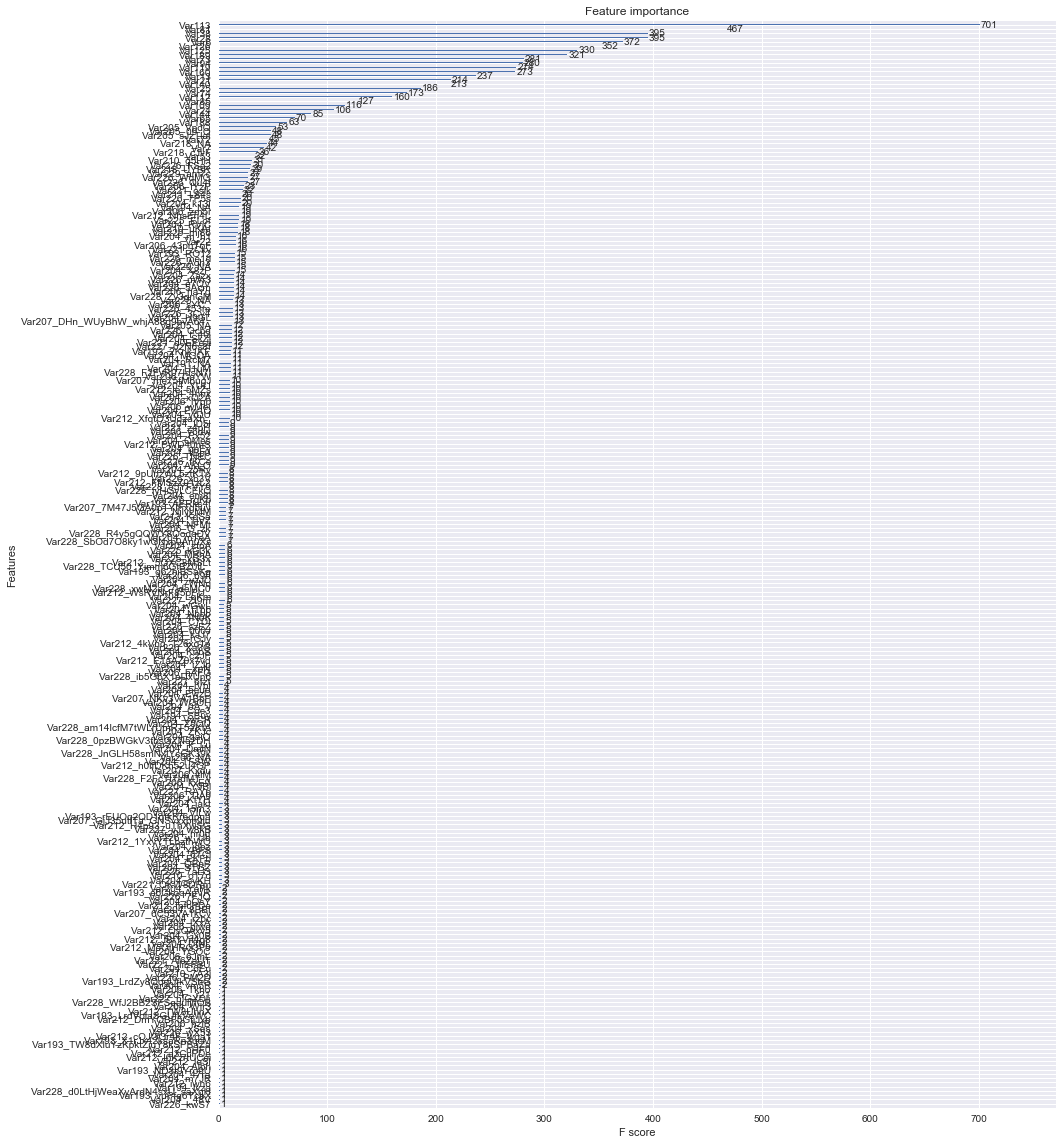

In [133]:
fig, ax = plt.subplots(figsize=(15, 20))
xgb.plot_importance(grid_search_cv.best_estimator_, ax=ax)
plt.show()

Среди наиболее важных признаков большое количество вещественных.

## 4. Построение итоговой модели.

Для построения финальной модели на основе XGBClassifier будем использовать:
- выборку на основе признаков, отобранных по значимости корреляции с целевой переменной.
- применим undersampling и сделаем количество объектов класса `отток` в 2 раза больше числа объекто класса `не отток`.
- заполним медианными значениями по столбцу для вещественных признаков.
- используем dummy - кодирование для обработки категориальных признаков с небольшим количеством категорий.
- используем подобранные по сетке параметры {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.7}.

In [37]:
numeric_data_selected_train.head()
categorial_data_selected_train.head()

,Var189,Var74,Var13,Var7,Var140,Var125,Var126,Var73,Var6,Var65,...,Var22,Var25,Var28,Var85,Var188,Var94,Var24,Var109,Var38,Var53
0,NaN,0.0,0.0,0.0,0.0,4923.0,NaN,48.0,168.0,9.0,...,120.0,96.0,133.12,0.0,NaN,NaN,0.0,0.0,0.0,NaN
1,318.0,182.0,820.0,7.0,5500.0,4869.0,-24.0,86.0,1155.0,18.0,...,380.0,48.0,253.52,0.0,NaN,253872.0,0.0,8.0,2740026.0,NaN
2,156.0,14.0,4.0,7.0,45.0,171.0,-28.0,32.0,686.0,9.0,...,170.0,64.0,253.52,6.0,NaN,1374.0,4.0,32.0,2858460.0,NaN
3,NaN,238.0,300.0,7.0,265.0,8001.0,NaN,42.0,798.0,9.0,...,170.0,32.0,186.64,4.0,NaN,NaN,2.0,32.0,6336420.0,NaN
4,360.0,49.0,1080.0,7.0,9455.0,551979.0,32.0,56.0,3108.0,9.0,...,510.0,280.0,233.44,34.0,NaN,447552.0,12.0,144.0,0.0,NaN


,Var213,Var194,Var191,Var201,Var216,Var204,Var211,Var226,Var193,Var210,...,Var225,Var212,Var227,Var228,Var229,Var205,Var206,Var192,Var199,Var218
0,NaN,NaN,NaN,NaN,TDcECyH,t_4G,L84s,Qu4f,RO12,uKAI,...,ELof,NhsEn4L,RAYp,F2FyR07IdsN7I,mj86,VpdQ,IYzP,eOQt0GoOh3,h3WsUQk,cJvF
1,NaN,NaN,NaN,NaN,XTbPUYD,rGJy,Mtgm,Qu4f,RO12,uKAI,...,ELof,XfqtO3UdzaXh_,RAYp,F2FyR07IdsN7I,am7c,09_Q,lVqb,yaKt0Go8Lb,daiGnRstPa,UYBR
2,NaN,NaN,NaN,NaN,NGZXfGp,k13i,L84s,fKCe,RO12,uKAI,...,NaN,NhsEn4L,RAYp,F2FyR07IdsN7I,NaN,sJzTlal,zm5i,6m0t0G8rTN,k2w937Sptb8I4AR_,cJvF
3,NaN,NaN,NaN,NaN,mAja5EA,Y9Bl,L84s,uWr3,RO12,uKAI,...,NaN,NhsEn4L,RAYp,F2FyR07IdsN7I,NaN,NaN,zm5i,EsYq9aX0Db,UFIZdCX,UYBR
4,NaN,NaN,NaN,NaN,kq0n8Bj,e7QV,L84s,fKCe,RO12,uKAI,...,ELof,NhsEn4L,RAYp,F2FyR07IdsN7I,NaN,VpdQ,sYC_,6m0t0G8rTN,k10MzgT,cJvF


Вещественные признаки.

In [40]:
# заменяем пропущенные значения  вещественных признаков нулями
numeric_data_selected_train = numeric_data_selected_train.fillna(0)
# заменяем пропущенные значения  вещественных признаков медианами по столбцу
numeric_data_selected_train = numeric_data_selected_train.fillna(numeric_data_selected_train.median())

Категориальные признаки.

In [42]:
# обработаем категории
categorial_data_select_for_model = categorial_data_selected_train.dropna(axis=1,how='all').copy()
# заменяем пропущенные значения  категориальных признаков еще обной категорие (так мы не потеряем информацию о признаках)
categorial_data_select_for_model = categorial_data_select_for_model.fillna('NA').astype(str)
# обработаем категориальные признаки с использованием метода LabelEncoder
categorial_data_select_for_model = labelEncoder(categorial_data_select_for_model) 

Объединим все в один датасет.

In [43]:
result_dataset = pd.concat([numeric_data_selected_train, categorial_data_select_for_model],axis=1)
result_dataset.shape

(32000, 50)

Сделаем соотношение класса `отток` и `не отток` 1 к 2.

In [44]:
idx_negative = result_dataset[labels_data_train == 1].index.tolist()
idx_positive = result_dataset[labels_data_train == -1].index.tolist()
len(idx_negative)
len(idx_positive)

2381

29619

In [45]:
negative_class = list(np.random.choice(idx_negative, 6*len(idx_negative)))
len(negative_class)
positive_class = list(np.random.choice(idx_positive, 3*len(idx_negative)))
len(positive_class)

14286

7143

Итоговый датасет для подбора параметров модели.

In [46]:
dataset_for_our_model = result_dataset.ix[negative_class+positive_class]
labels_data = labels_data_train[negative_class+positive_class]

Зададим стратегию кросс-валидации с разбиением на 5 фолдов.

In [47]:
cross_val_strategy = StratifiedKFold(n_splits=5, random_state=100)

In [49]:
%%time
xgboost_result_model = xgb.XGBClassifier( learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.7, eval_metric='auc', random_state=44, n_jobs=-1)
roc_auc, pr_auc, precision, recall, f1_score, models = calculate_classification_metrics(xgboost_result_model, cross_val_strategy, dataset_for_our_model, labels_data)

ROC-AUC: 0.959494654503304
PR-AUC: 0.9710640721653121
Accuracy: 0.8976621286313312
Precision: 0.8734575274869352
Recall: 0.9899202062972288
F1-score: 0.9280445777753282
Wall time: 10min 16s


Проверим качество модели на отложеной (holdout) выборке.

In [63]:
numeric_data_selected_test.shape
categorial_data_selected_test.shape
labels_data_test.shape

(8000, 28)

(8000, 22)

(8000,)

In [64]:
def feature_enginering_holdout(numeric_dataset, categorial_dataset, label_data):
    # Вещественные признаки
    # заменяем пропущенные значения  вещественных признаков нулями
    numeric_dataset = numeric_dataset.fillna(0)
    # заменяем пропущенные значения  вещественных признаков медианами по столбцу
    numeric_dataset = numeric_dataset.fillna(numeric_dataset.median())
    # категориальные признаки
    # обработаем категории
    categorial_data_select_for_model = categorial_dataset.dropna(axis=1,how='all').copy()
    # заменяем пропущенные значения  категориальных признаков еще обной категорие (так мы не потеряем информацию о признаках)
    categorial_data_select_for_model = categorial_data_select_for_model.fillna('NA').astype(str)
    # обработаем категориальные признаки с использованием метода LabelEncoder
    categorial_data_select_for_model = labelEncoder(categorial_data_select_for_model) 
    result_dataset = pd.concat([numeric_dataset, categorial_data_select_for_model],axis=1)
    idx_negative = result_dataset[label_data == 1].index.tolist()
    idx_positive = result_dataset[label_data == -1].index.tolist()
    negative_class = list(np.random.choice(idx_negative, 6*len(idx_negative)))
    positive_class = list(np.random.choice(idx_positive, 3*len(idx_negative)))
    dataset_for_our_model = result_dataset.ix[negative_class+positive_class]
    label_data_for_our_model = label_data[negative_class+positive_class]
    return dataset_for_our_model, label_data_for_our_model

In [65]:
data_for_test_model, label_for_test_model = feature_enginering_holdout(numeric_data_selected_test, categorial_data_selected_test, labels_data_test)
data_for_test_model.shape
label_for_test_model.shape

(5355, 50)

(5355,)

In [66]:
finish_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.7, eval_metric='auc', random_state=44, n_jobs=-1).fit(dataset_for_our_model, labels_data)
pred_answers = finish_model.predict(data_for_test_model)

In [84]:
print(classification_report(label_for_test_model, pred_answers))

              precision    recall  f1-score   support

          -1       0.45      0.71      0.55      1785
           1       0.79      0.56      0.66      3570

    accuracy                           0.61      5355
   macro avg       0.62      0.63      0.60      5355
weighted avg       0.68      0.61      0.62      5355



In [91]:
roc_auc_result = sm.roc_auc_score(label_for_test_model, pred_answers)
precision_result = sm.precision_score(label_for_test_model, pred_answers)
recall_result = sm.recall_score(label_for_test_model, pred_answers)
print(roc_auc_result, precision_result, recall_result)

0.6333333333333333 0.7925426418088061 0.5596638655462185


В результате построения модели и проверки ее качества получили, что наша модель угадывает пользователей склонных к оттоку в 79% случаев, но при этом срабатывает всего на 56% пользователей склонных к оттоку.

В качестве улучшения модели можно добавить новых признаков на основе имеющихся (например создать попарные взаимодействия важных категориальных признаков).
Также ситуацию с качеством предсказания может улучшить построение ансамбля моделей.

## 5. Ожидаемый экономический эффект.

Поскольку исходными данными по абонентам компании Orange пользоваться затруднительно (маленький объем данных, неизвестно  назначение признаков, а также нет актуальных достоверных открытых данных по количеству абонентов компании Orange, стоимости их привлечения и среднего дохода от каждого пользователя).

Воспользуемся данными из открытых источников. Данные по абонентам возьмем из подведения итогов 2019 года компанией Tele2 (https://eaomedia.ru/news/917792/). Применим данные по среднему доходу от каждого абонента на имеющиеся данные и получим следующие значения:
- ARPU (Average Revenue Per User) — средний доход, который мы получаем от каждого активного пользователя (305 рублей в месяц).

- Users - число абонентов 40 тысяч.

- Churn - средний отток 7%.

- N - число пользователей, склонных к оттоку (40000 * 0.07 = 2800 пользователей).
- n_topX - доля удерживаемых пользователей от числа всех пользователей склонных к оттоку (от 0 до 1).

- CRC (Customer Retention Cost) - объем вложений в удержание одного пользователя. Сделаем данный параметр 30% от ARPU (92 рубля).

- p - вероятность принятия предложения (в каждом отдельном случае будем подбирать указанный параметр и оценивать экономический эффект, по умолчанию - 0.5).
- precision - точность модели.

#### Экономический эффект от проведения компании.

Расходы на проведение кампании будут рассчитываться по следующей формуле:

$$Expenses= CRC \cdot n_{top_X} \cdot N$$

Доходы по следующей формуле:

$$Revenue= n_{top_X} \cdot N \cdot ARPU\cdot p$$

Экономический эффект получим по следующей формуле:

$$Efficiency = Revenue - Expenses = N \cdot n_{top_X} \cdot ARPU\cdot p - CRC \cdot n_{top_X} \cdot N$$ 

Формула оценки эффективности удержания будет выглядеть следующим образом:

$$Efficiency = N \cdot precision \cdot n_{top_X} \cdot  ARPU\cdot p - CRC \cdot n_{top_X} \cdot N$$

Посчитаем экономический эффект от проведения компании.

Возьмем долю удерживаемых пользователей n_topX равной 25%. Вероятность p, что пользователь останестя равной 0.5.

In [103]:
Users = 40000
Churn = 0.07
precision = 0.8
N = 2800
p = 0.5
n_top_x = 0.25
CRC = 92
ARPU = 305

In [104]:
def efficiency_score (N, p, n_top_x, ARPU, CRC):
    return (N * ARPU * p * n_top_x) - (N * CRC * n_top_x)

In [105]:
efficiency = efficiency_score(N, p, n_top_x, ARPU, CRC)
print("Экономический эффект от проведения компании по удержанию: {} руб.".format(efficiency))

Экономический эффект от проведения компании по удержанию: 42350.0 руб.


#### Расчет топа пользователей склонных к оттоку согласно модели, используемых в кампании по удержанию.

Согласно формуле, эффект прямо пропорционален количеству пользователей, поэтому чем
больше пользователей мы вовлечем в компанию, тем больше прибыли получим.
$$Efficiency = Revenue - Expenses = N \cdot n_{top_X} \cdot  ARPU\cdot p - CRC \cdot n_{top_X} \cdot N$$
N * n_top_X – количество удерживаемых пользователей,
p – вероятность удержания пользователя,
ARPU – средний доход с пользователя.

В более сложной модели надо учитывать, что полнота и точность будут варьироваться
для top 1% и для top 25% и необходимо учесть, что в top% пользователей попадут не только желающие покинуть оператора, но и обычные пользователи, поэтому их надо будет исключить из расчетов (взять только долю precision).

#### Усложение экономической модели. 

Добавим параметр точность модели(precision) и предположим, что точность зависит от количества пользователей,вовлеченных в кампанию.

Пусть она убывает со 100% (для одного пользователя) до 50%(для всех пользователей).

В результате итоговая формула оценки эффективности удержания будет выглядеть следующим образом:

$$Efficiency = N \cdot precision \cdot n_{top_X} \cdot  ARPU\cdot p - CRC \cdot n_{top_X} \cdot N$$

In [106]:
def efficiency_score_with_precision (N, p, n_top_x, ARPU, CRC, precision):
    return (N * ARPU * precision * p * n_top_x) - (N * CRC * n_top_x)

Оценим экономический эффект в зависимости от числа удерживаемых пользователей и от точности модели.

<function matplotlib.pyplot.show>

<function matplotlib.pyplot.show>

<function matplotlib.pyplot.show>

<function matplotlib.pyplot.show>

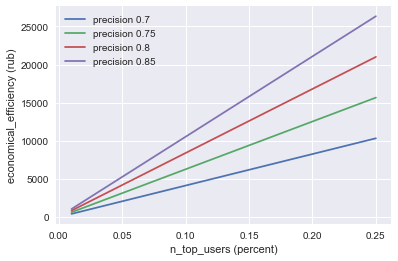

In [107]:
n_top_x = np.linspace(0.01,0.25,25)
precision_list = [0.7, 0.75, 0.8, 0.85]
for precision in precision_list:
    _ = plt.plot(n_top_x, efficiency_score_with_precision(N, p, n_top_x, ARPU, CRC, precision))
    _ = plt.legend(['precision 0.7', 'precision 0.75', 'precision 0.8', 'precision 0.85'])
    _ = plt.xlabel('n_top_users (percent)')
    _ = plt.ylabel('economical_efficiency (rub)')
    _ = plt.grid()
    plt.show

Из графика видно, что модель с точностью более 70% дают положительного экономического эффект для группы (от 1 до 25%) пользователей склонных к оттоку и используемых в нашей экономической компании.

#### Когда применение модели экономически неоправдано?

Возьмем оптимальные параметры согласно построенной нами модели (precision = 0.8, n_top_X =0.25) и рассчитаем когда ее применение становится экономически неоправданным.

<function matplotlib.pyplot.show>

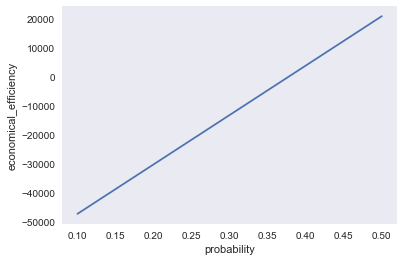

In [110]:
p = np.linspace(0.1, 0.5, 5)
precision = 0.8
N = 2800
n_top_x = 0.25
CRC = 92
ARPU = 305
_ = plt.plot(p, efficiency_score_with_precision(N, p, n_top_x, ARPU, CRC, precision))
_ = plt.legend()
_ = plt.xlabel('probability')
_ = plt.ylabel('economical_efficiency')
_ = plt.grid()
plt.show

Из графика видно, что в случае если пользователь остается с вероятностью менее 40%, то модель ялвяется экономически невыгодной.

#### Оценка изменения экономического эффекта от проведения кампании по удержанию.

Возьмем оптимальные параметры согласно построенной нами модели (precision = 0.8, n_top_X = 0.25) и подсчитаем эффективность проедения компании.

In [111]:
p = 0.5
precision = 0.8
N = 2800
n_top_x = 0.25
CRC = 92
ARPU = 305
optimal_efficiency = efficiency_score_with_precision(N, p, n_top_x, ARPU, CRC, precision)
print("Экономический эффект от проведения компании по удержанию при оптимальных параметрах: {} руб.".format(optimal_efficiency))

Экономический эффект от проведения компании по удержанию при оптимальных параметрах: 21000.0 руб.


Теперь рассчитаем выгодно ли увеличение качества модели.
Введем параметр стоимости увеличения качества модели (improvecost) и коэффициент улучшения качеста модели (addcoef). В результате получится следующая формула для подсчета качества модели:
$$Efficiency = N \cdot (precision + addcoef) \cdot n_{top_X} \cdot  ARPU\cdot p - CRC \cdot n_{top_X} \cdot N - improvecost$$

In [112]:
def improve_efficiency_score_with_precision (N, p, n_top_x, ARPU, CRC, precision, improvecost, addcoef):
    return (N * ARPU * (precision + addcoef) * p * n_top_x) - (N * CRC * n_top_x) - improvecost

#### Оценим экономический эффект при улучшении качества модели на 1%.

Стоимость увеличения качества модели на 1% сделаем для примера равной 1000 рублей.

In [117]:
p = 0.5
addcoef = 0.01
improvecost = 1000
precision = 0.8
N = 2800
n_top_x = 0.25
CRC = 92
ARPU = 305
add_one_percent_efficiency = improve_efficiency_score_with_precision(N, p, n_top_x, ARPU, CRC, precision, improvecost, addcoef)
print("Экономический эффект от проведения компании по удержанию при увеличении точности на 1%: {} руб.".format(add_one_percent_efficiency))

Экономический эффект от проведения компании по удержанию при увеличении точности на 1%: 21067.5 руб.


In [118]:
print('Улучшение точности модели на 1% дало следующий экономический эффект: {} руб.'.format(add_one_percent_efficiency - optimal_efficiency))

Улучшение точности модели на 1% дало следующий экономический эффект: 67.5 руб.


В целом при большом количестве абонентов будет заметно увеличение прибыли при увеличении качества модели на 1%.

#### Оценим экономический эффект при улучшении качества модели на 3%.

На этот раз стоимость увеличения качества модели на 3% будет равна 3000 рублям.

In [120]:
p = 0.5
addcoef = 0.03
improvecost = 3000
precision = 0.8
N = 2800
n_top_x = 0.25
CRC = 92
ARPU = 305
add_three_percent_efficiency = improve_efficiency_score_with_precision(N, p, n_top_x, ARPU, CRC, precision, improvecost, addcoef)
print("Экономический эффект от проведения компании по удержанию при увеличении точности на 3%: {} руб.".format(add_three_percent_efficiency))

Экономический эффект от проведения компании по удержанию при увеличении точности на 3%: 21202.500000000015 руб.


In [121]:
print('Улучшение точности модели на 3% дало следующий экономический эффект: {} руб.'.format(add_three_percent_efficiency - optimal_efficiency))

Улучшение точности модели на 3% дало следующий экономический эффект: 202.50000000001455 руб.


Заметен рост прибыли при увеличении качества модели на 3%.

В качестве эксперимента посчитаем экономический эффект при увеличении качества модели, при условии, что в удержании участвуют всего top10% пользователей. Улучшать качество модели будем также на 1 и 3%. Затраты на повышение точности модели остаются прежними.

In [122]:
p = 0.5
addcoef_3 = 0.03
addcoef_1 = 0.01
improvecost_3 = 3000
improvecost_1 = 1000
precision = 0.8
N = 2800
n_top_x = 0.1
CRC = 92
ARPU = 305
add_one_percent_efficiency_top_10 = improve_efficiency_score_with_precision(N, p, n_top_x, ARPU, CRC, precision, improvecost_1, addcoef_1)
print("Экономический эффект от проведения компании по удержанию при увеличении точности на 3%: {} руб.".format(add_one_percent_efficiency_top_10))
print('Улучшение точности модели на 3% при 10% пользователей дало следующий экономический эффект: {} руб.'.format(add_one_percent_efficiency_top_10 - optimal_efficiency))
add_three_percent_efficiency_top_10 = improve_efficiency_score_with_precision(N, p, n_top_x, ARPU, CRC, precision, improvecost_3, addcoef_3)
print("Экономический эффект от проведения компании по удержанию при увеличении точности на 3%: {} руб.".format(add_three_percent_efficiency_top_10))
print('Улучшение точности модели на 3% при 10% пользователей дало следующий экономический эффект: {} руб.'.format(add_three_percent_efficiency_top_10 - optimal_efficiency))

Экономический эффект от проведения компании по удержанию при увеличении точности на 3%: 7827.0 руб.
Улучшение точности модели на 3% при 10% пользователей дало следующий экономический эффект: -13173.0 руб.
Экономический эффект от проведения компании по удержанию при увеличении точности на 3%: 6681.000000000007 руб.
Улучшение точности модели на 3% при 10% пользователей дало следующий экономический эффект: -14318.999999999993 руб.


#### Является ли экономически оправданным вложение средств в улучшение качества модели?

Из результатов видно, что для топ10% пользователей и соответствующей ей точности увеличивать качество модели экономически невыгодно.
Для топ25% увеличение качества модели является экономически оправданным и можно получить дополнительную прибыль.

Считая, что пользователи примут наше предложение всего лишь с
вероятностью 50% и применяя методики удержания с бюджетом 92 рубля на человека  к top 25%  от числа пользователей склонных к оттоку (всего к оттоку склонно 2800 пользователей из наших данных) можем получить дополнительную прибыль порядка 15 тыс рублей (с учетом, что в модели участвовали данные только по 40 тысячам абонентов)!

## 6. Итоги.

Результатом проделанной работы является обученная на подготовленных данных модель XGBClassifier, готовая к практическому применению. Также была проделана работа по оценке качества и экономического эффекта от применения.

### Улучшение модели

Для улучшения модели можно добавить еще данных по абонентам, чтобы модель смогла найти больше закономероностей  в данных.
Но оптимальным вариантом будет использование ансамбля из моделей, а также построение  дополнительных признаков на основе самых информативных.

### Внедрение модели

Для внедренния модели необходимо произвести автматизацию процесса предобработки данных согласно алгоритму.

### Тестирование модели

Для оценки реального экномического эффекта необходимо тестировать получившуюся модель на группе пользователей (АБ - тестирование).